# Objective Evaluations - Scores

In [1]:
import pandas as pd
from scipy.stats import f_oneway

In [2]:
resp_data = pd.read_csv('questionnaire\\long_term\\response_summary_long.csv')
resp_data.head(5)

,strategy,topic,corpus,method,participant,score,recall,theme
0,AN,AN_G,G,1,1,2,1,0
1,AN,AN_O,O,0,1,3,5,4
2,EE,EE_G,G,1,1,2,4,3
3,EE,EE_O,O,0,1,1,0,1
4,IL,IL_G,G,0,1,2,4,2


## Mix-up

In [4]:
# Group by 'method' and compute mean and std of 'score'
grouped_data = resp_data.groupby('method')['score'].agg(['mean', 'std'])

# Perform ANOVA test
anova_result = f_oneway(*[group['score'] for name, group in resp_data.groupby('method')])

# Print the mean and std of 'score' for each 'method'
print("Mean and Standard Deviation of 'score' by 'method':")
print(grouped_data)

# Print the ANOVA test result
print("\nANOVA Test Result:")
print("F-value:", anova_result.statistic)
print("p-value:", anova_result.pvalue)

Mean and Standard Deviation of 'score' by 'method':
            mean       std
method                    
0       2.785714  1.140720
1       2.647059  0.942602

ANOVA Test Result:
F-value: 0.6039999951061416
p-value: 0.43840563785682507


## Add strategy

In [6]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

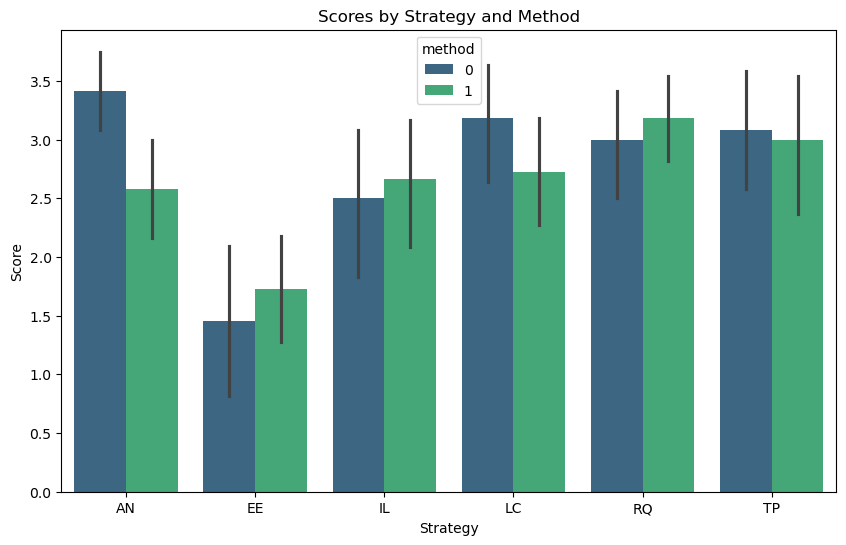

In [7]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='strategy', y='score', hue='method', data=resp_data, palette='viridis')

# Set plot title and labels
plt.title('Scores by Strategy and Method')
plt.xlabel('Strategy')
plt.ylabel('Score')

# Display the plot
plt.show()

## Shirley's Method

for each participant {
    baseline_score_g = mean(method==0, G);
    baseline_score_o = mean(method==0, O);
    for each passage whose method == 1 {
        do pair t-test between the score (compare the score and the corresponding baseline, decided by G or O)
    }
}

## Add overall recall and theme recall

recall: overall recall

theme: the question 6

overall: the total score

In [10]:
import pandas as pd
from scipy.stats import ttest_rel

# Step 1: Load the data and split by method
df = pd.read_csv('questionnaire\\long_term\\response_summary_long.csv')

# Split into two dataframes based on method
df_method_0 = df[df['method'] == 0]
df_method_1 = df[df['method'] == 1]

# Function to compute baseline scores
def compute_baseline(df_method_0, column_name):
    baseline_scores = df_method_0.groupby(['participant', 'corpus'])[column_name].mean().reset_index()
    baseline_scores.rename(columns={column_name: f'baseline_{column_name}'}, inplace=True)
    return baseline_scores

# Compute baseline scores for 'score', 'recall', and 'theme'
baseline_score = compute_baseline(df_method_0, 'score')
baseline_recall = compute_baseline(df_method_0, 'recall')
baseline_theme = compute_baseline(df_method_0, 'theme')
baseline_overall = compute_baseline(df_method_0, 'overall')

# Merge the baseline scores with method==1 dataframe
df_method_1_merged = pd.merge(df_method_1, baseline_score, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_recall, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_theme, on=['participant', 'corpus'])
df_method_1_merged = pd.merge(df_method_1_merged, baseline_overall, on=['participant', 'corpus'])

# Function to perform t-test and print results
def perform_t_test(df_method_1_merged, column_name):
    t_stat, p_value = ttest_rel(df_method_1_merged[column_name], df_method_1_merged[f'baseline_{column_name}'])
    average_score_method_0 = df_method_0[column_name].mean()
    average_score_method_1 = df_method_1_merged[column_name].mean()
    print(f"Average {column_name} for method 0:", average_score_method_0)
    print(f"Average {column_name} for method 1:", average_score_method_1)
    print(f"T-statistic for {column_name}:", t_stat)
    print(f"P-value for {column_name}:", p_value)
    print('\n')

# Perform t-tests for 'score', 'recall', and 'theme'
for column in ['score', 'recall', 'theme', 'overall']:
    perform_t_test(df_method_1_merged, column)

# Save the merged dataframe with baseline columns to a single CSV file
df_method_1_merged.to_csv('questionnaire\\long_term\\t-test_results.csv', index=False)

Average score for method 0: 2.7857142857142856
Average score for method 1: 2.6666666666666665
T-statistic for score: -1.0173065999021575
P-value for score: 0.3119638666581514


Average recall for method 0: 2.988095238095238
Average recall for method 1: 3.7261904761904763
T-statistic for recall: 2.900199442610394
P-value for recall: 0.004771668723558078


Average theme for method 0: 2.1547619047619047
Average theme for method 1: 2.0833333333333335
T-statistic for theme: -0.44343059466780627
P-value for theme: 0.6586080560897086


Average overall for method 0: 7.928571428571429
Average overall for method 1: 8.476190476190476
T-statistic for overall: 1.471080914707763
P-value for overall: 0.14505048433247944




In [8]:
strategies = df_method_1_merged.strategy.unique()
for strategy in strategies:
    df_strategy = df_method_1_merged[df_method_1_merged['strategy'] == strategy]
    
    for column in ['score', 'recall', 'theme']:
        t_stat, p_value = ttest_rel(df_strategy[column], df_strategy[f'baseline_{column}'])
        average_baseline = df_strategy[f'baseline_{column}'].mean()
        average_score = df_strategy[column].mean()
        
        print(f"Strategy: {strategy}")
        print(f"Average baseline {column}:", average_baseline)
        print(f"Average {column}:", average_score)
        print(f"T-statistic for {column}:", t_stat)
        print(f"P-value for {column}:", p_value)
        print()

Strategy: AN
Average baseline score: 2.5714285714285716
Average score: 2.4285714285714284
T-statistic for score: -0.49319696191607193
P-value for score: 0.6300997501827964

Strategy: AN
Average baseline recall: 3.4285714285714284
Average recall: 3.5
T-statistic for recall: 0.08787060554107277
P-value for recall: 0.9313186836543497

Strategy: AN
Average baseline theme: 1.976190476190476
Average theme: 2.857142857142857
T-statistic for theme: 1.8309101722280445
P-value for theme: 0.09012396436009242

Strategy: EE
Average baseline score: 3.0238095238095233
Average score: 1.9285714285714286
T-statistic for score: -4.5512476774711725
P-value for score: 0.0005439034849870229

Strategy: EE
Average baseline recall: 3.0952380952380953
Average recall: 2.857142857142857
T-statistic for recall: -0.46860921309188386
P-value for recall: 0.6471095854170311

Strategy: EE
Average baseline theme: 2.2857142857142856
Average theme: 1.6428571428571428
T-statistic for theme: -2.698962137190177
P-value for t

## Visualization

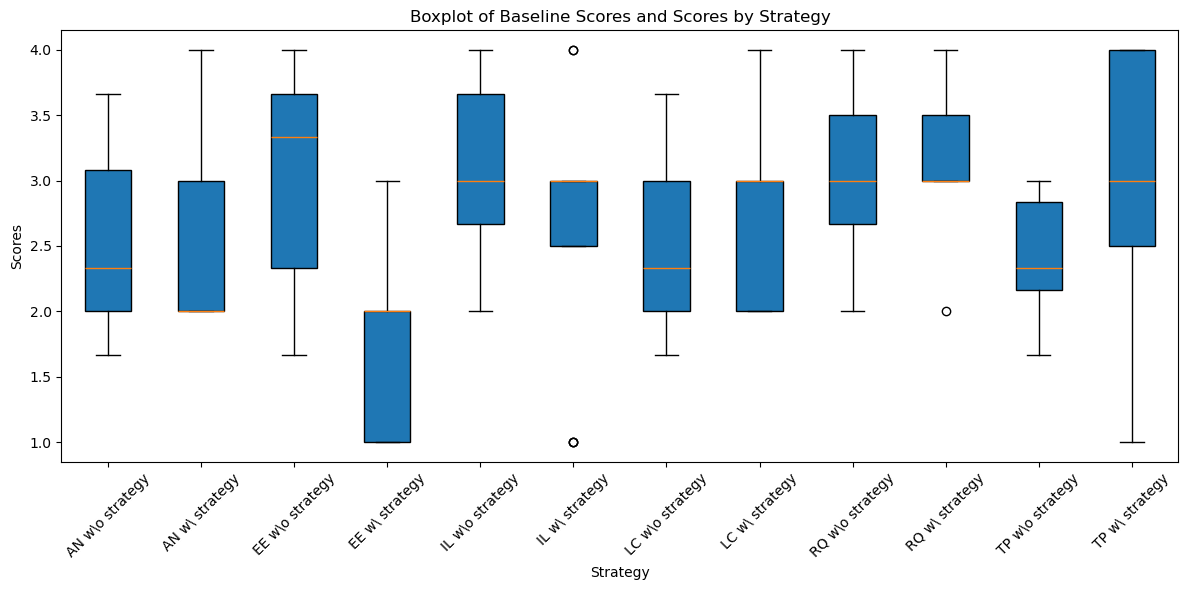

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV data into a DataFrame
data = pd.read_csv('questionnaire\\long_term\\t-test_result.csv')

# Extract relevant columns for each strategy
strategies = data['strategy'].unique()
boxplot_data = []
labels = []

for strategy in strategies:
    strategy_data = data[data['strategy'] == strategy]
    boxplot_data.append(strategy_data['baseline'].values)
    boxplot_data.append(strategy_data['score'].values)
    labels.append(f'{strategy} w\\o strategy')
    labels.append(f'{strategy} w\\ strategy')

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(boxplot_data, labels=labels, patch_artist=True)

plt.xlabel('Strategy')
plt.ylabel('Scores')
plt.title('Boxplot of Baseline Scores and Scores by Strategy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()